# ПР-6: Линейная регрессия

## Читаем датасет

In [1]:
import pandas as pd

In [2]:
raw_data = pd.read_csv(r'exams - exams.csv', encoding='UTF-8')
print(raw_data)

     gender race/ethnicity parental level of education         lunch  \
0    female        group D                some college      standard   
1      male        group D          associate's degree      standard   
2    female        group D                some college  free/reduced   
3      male        group B                some college  free/reduced   
4    female        group D          associate's degree      standard   
..      ...            ...                         ...           ...   
995    male        group C                some college      standard   
996    male        group C                some college      standard   
997  female        group A                 high school      standard   
998    male        group E                 high school      standard   
999    male        group D                 high school      standard   

    test preparation course  math score  reading score  writing score  
0                 completed          59             70         

## Делаем датасет числовым

In [3]:
raw_data.columns

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score'],
      dtype='object')

In [4]:
print( 'gender:', raw_data['gender'].unique() )
print( 'race/ethnicity:', raw_data['race/ethnicity'].unique() )
print( 'parental level of education:', raw_data['parental level of education'].unique() )
print( 'lunch:', raw_data['lunch'].unique() )
print( 'test preparation course:', raw_data['test preparation course'].unique() )

gender: ['female' 'male']
race/ethnicity: ['group D' 'group B' 'group C' 'group E' 'group A']
parental level of education: ['some college' "associate's degree" 'some high school'
 "bachelor's degree" "master's degree" 'high school']
lunch: ['standard' 'free/reduced']
test preparation course: ['completed' 'none']


In [5]:
def preprocessing( df : pd.DataFrame ) -> pd.DataFrame:
    df_ = df.copy()
    
    gender_map = {'male': 0, 'female': 1}
    df_['gender'] = df['gender'].map(gender_map)

    racist_map = {'group A': 0, 'group B': 1, 'group C': 2, 'group D': 3, 'group E': 4}
    df_['race/ethnicity'] = df['race/ethnicity'].map(racist_map)

    edu_map = {
    'some high school': 0,
    'high school': 1,
    'some college': 2,
    'associate\'s degree': 3,
    'bachelor\'s degree': 4,
    'master\'s degree': 5,
    }
    df_['parental level of education'] = df['parental level of education'].map(edu_map)

    lunch_map = {'free/reduced': 0, 'standard': 1}
    df_['lunch'] = df['lunch'].map(lunch_map)

    prepare_map = {'none': 0, 'completed': 1}
    df_['test preparation course'] = df['test preparation course'].map(prepare_map)

    cols_to_drop = []
    df_ = df_.drop(columns = [col for col in df_.columns if col in cols_to_drop])

    return df_

In [6]:
data = preprocessing(raw_data)
data

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,1,3,2,1,1,59,70,78
1,0,3,3,1,0,96,93,87
2,1,3,2,0,0,57,76,77
3,0,1,2,0,0,70,70,63
4,1,3,3,1,0,83,85,86
...,...,...,...,...,...,...,...,...
995,0,2,2,1,0,77,77,71
996,0,2,2,1,0,80,66,66
997,1,0,1,1,1,67,86,86
998,0,4,1,1,0,80,72,62


## Делим датасет на обучающую и тестовую часть: 70/30 соответственно
> На 700 будет строится гипотеза, а оставшиеся 300 -- для проверки

In [7]:
data_for_learn = data.head(int(len(data) * 0.7))
data_for_tests = data.tail(int(len(data) * 0.3))
print( len(data_for_learn), len(data_for_tests) )

700 300


## Регрессионный анализ
> Мы предполагаем что некоторый параметр $y$ зависит от параметров $x_1 , x_2 , ... , x_n$
>
> Тогда на их основе можно прогнозировать $y$:
>
> $y = k_0 + k_1*x_1 + k_2*x_2~ +... + ~k_n*x_n$
>
> (это просто линейная аппроксимация)

> На самом деле мы анализируем не по одному значению, а по целой выборке -- каждый из параметров это вектор. Задача линейной регрессии превращается в задачу множественной регрессии. Смысл тот же
>
> Предсказание y:
> $$y_i^{предск.} = \sum_{k=0}^{m-1}\beta_kx_i^k+\alpha$$
> Функция ошибки:
> $$F(\alpha, \beta_0, ..., \beta_{m-1})=\sum_{i=0}^{n-1}(y_i^{предск.}-y_i^{реальн.})^2$$
> Условие миниимума $F$:
> $$\frac{\delta F}{\delta\alpha} = \frac{\delta F}{\delta\beta_l} = 0$$
> Преобразуя, получаем СЛАУ с коэффициентами:
> $$\beta_0\sum_{i=0}^{n-1}x_i^0 ~+...+~ \beta_{m-1}\sum_{i=0}^{n-1}x_i^{m-1} + n\alpha = \sum_{i=0}^{n-1}y_i$$
> $$\beta_0\sum_{i=0}^{n-1}x_i^0 x_i^l ~+...+~ \beta_{m-1}\sum_{i=0}^{n-1}x_i^{m-1}x_i^l + \alpha\sum_{i=0}^{n-1}x_i^l = \sum_{i=0}^{n-1}y_i x_i^l$$
> $$l = 0,~...,~m-1$$

> Остаётся привести в подходящий вид и решить, например, методом Гаусса

### Метод Гаусса для решения СЛАУ

In [8]:
def printM(M):
    for row in M:
        print(f" > {len(row)}:")
        print(row)

# Ax=b
def Gauss(myA : list[list], b : list) -> list: 
    #print(50*'=')
    #print("### Решение")
    #print(50*'=')
    
    A = [ row[:] for row in myA ]
    rows = len(A)
    
    # Объединяем в одну матрицу для удобства
    for r in range(rows): A[r].append(b[r])
    cols = len(A[0])
    
    #print("Матрица:")
    #printM(A)
    #print(50*'=')
    #print(50*'=')
    # Прямой ход
    for row in range(rows):
        col = row
        maxRow = row
        for r in range(row+1, rows):
            if abs(A[r][col]) > abs(A[maxRow][col]): maxRow = r
        ## Меняем текущую строку и строку с ведущим элементом
        A[row], A[maxRow] = A[maxRow], A[row]
        ## Нормализуем строку по ведущему элементу
        pivot = A[row][col]
        if not pivot: 
            print("Матрица не имеет решений, либо решений бесконечно много!")
            return []
        for c in range(col, cols):
            A[row][c] /= pivot
        ## Вычитаем текущую строку из нижних
        for r in range(row+1, rows):
            coeff = A[r][col]
            for c in range(cols):
                # Цель - обнулить элементы снизу (чтобы получился "треугольник")
                # Так как у ведущего коэффициент 1, домножаем на число под ним из нужной строки
                # Таким образом это число обнулится после вычитания
                A[r][c] -= coeff * A[row][c]
    #print("После прямого хода:")
    #printM(A)
    #print(50*'=')
    # Обратный ход
    x = [ 0 for _ in range(cols-1) ] # массив решений (там где не вычислено, будет 0)
    ## Идём с конца
    for i in range(rows-1, -1, -1):
        res = A[i][cols-1] # колонка b
        for k in range(i+1, cols-1):
            res -= x[k] * A[i][k] # Вычитаем из b уже вычисленные члены
            # (так как идём с конца, каждый раз будет оставаться один невычисленный с коэффициентом 1)
        x[i] = res # А вот и он
    print("Решение:")
    print(x)
    return x

# Проверка решения
def GaussTest(A : list[list], x : list, b : list, eps=1e-4) -> bool:
    print(50*'=')
    print("### Проверка")
    #print(50*'=')
    allOK = True
    for row, equ in enumerate(A):
        #print(equ)
        result = sum( c * x[i] for i, c in enumerate(equ))
        isOK = ( abs(result - b[row]) < eps)
        #print(f"{result} == {b[row]}?")
        #print(isOK)
        allOK = allOK and isOK
    #print(50*'=')
    print(">> Решение верное" if allOK else ">> Решение неверное")
    print(50*'=')
    return allOK

### Сам регрессионный анализ

In [9]:
# Скалярное произведение векторов
def dot(a: list, b: list):
    return sum([ax * bx for ax, bx in zip(a, b)])

# Xs - независимые векторы (n штук)
# y - зависимый вектор
def regression(Xs : list, y : list):
    n = len(y)
    M, b = [], []
    M.append([sum(x) for x in Xs] + [n]) # левая часть уравнения - суммы каждого вектора
    b.append(sum(y)) # правая часть уравнения -- сумма вектора y 
    for l, xl in enumerate(Xs): # Домножаем на вектор xl поочерёдно
        # Скалярное произведение
        M.append([dot(x, xl) for x in Xs] + [sum(xl)])
        b.append(dot(y,xl))
    beta = Gauss(M,b)
    if not GaussTest(M, beta, b): print('WARNING: Проверка показала неточное решение')
    return beta # вектор коэффициентов b0, ..., b{m-1}, a
                # a -- свободный член (кот который гуляет сам по себе)

## Строим модели линейной регрессии

In [10]:
def scalar_multipy(a, vec):
    return [a*v for v in vec]

import numpy as np
# Вычисление предсказанного y из заданных коэффициентов и заданных векторов
def multi_linear_approx(beta, Xs):
    # У нас матрица признаков*количество, а нужно количество*признаков
    # транспонируем
    Xs_ = np.array(Xs).T.tolist()
    # Не забываем что coeffs[-1] -- свободный член
    y = []
    for x in Xs_ :
        y.append( sum(x_i * b for x_i, b in zip(x, beta[:-1])) + beta[-1] )
    return y # возвращает вектор предсказанных значений

### A) Результат экзамена не зависит от результата прошедших экзаменов

In [11]:
dependences_a = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
Xs_a = [data_for_learn[col].to_list() for col in dependences_a]
y_a_math  = data_for_learn['math score'].to_list()
y_a_read  = data_for_learn['reading score'].to_list()
y_a_write = data_for_learn['writing score'].to_list()

coeffs_a_math  = regression(Xs_a, y_a_math)
coeffs_a_read  = regression(Xs_a, y_a_read)
coeffs_a_write = regression(Xs_a, y_a_write)

appr_y_a_math  = multi_linear_approx(coeffs_a_math, Xs_a)
appr_y_a_read  = multi_linear_approx(coeffs_a_read, Xs_a)
appr_y_a_write = multi_linear_approx(coeffs_a_write, Xs_a)

Решение:
[-5.80752389823877, 2.977606869434858, 1.4487855240053609, 11.747934989057578, 5.347019249825154, 51.20494524122714]
### Проверка
>> Решение верное
Решение:
[5.76404838393276, 1.9687737423954168, 1.1432571847516924, 7.741037534217565, 6.955075374380822, 53.10938288227729]
### Проверка
>> Решение верное
Решение:
[8.460600187352952, 2.2267061866392783, 1.6801074358723884, 8.454110923769727, 10.556709442819848, 47.160662285638836]
### Проверка
>> Решение верное


### B) Результат экзамена зависит от результата прошедших экзаменов

In [12]:
dependences_b = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
dependences_b_math  = dependences_b.copy()
dependences_b_read  = dependences_b + ['math score']
dependences_b_write = dependences_b + ['math score', 'reading score']
 
Xs_b_math  = [data_for_learn[col].to_list() for col in dependences_b_math]
Xs_b_read  = [data_for_learn[col].to_list() for col in dependences_b_read]
Xs_b_write = [data_for_learn[col].to_list() for col in dependences_b_write]

y_b_math  = data_for_learn['math score'].to_list()
y_b_read  = data_for_learn['reading score'].to_list()
y_b_write = data_for_learn['writing score'].to_list()

coeffs_b_math  = regression(Xs_b_math, y_b_math)
coeffs_b_read  = regression(Xs_b_read, y_b_read)
coeffs_b_write = regression(Xs_b_write, y_b_write)

appr_y_b_math  = multi_linear_approx(coeffs_b_math, Xs_b_math)
appr_y_b_read  = multi_linear_approx(coeffs_b_read, Xs_b_read)
appr_y_b_write = multi_linear_approx(coeffs_b_write, Xs_b_write)

Решение:
[-5.80752389823877, 2.977606869434858, 1.4487855240053609, 11.747934989057578, 5.347019249825154, 51.20494524122714]
### Проверка
>> Решение верное
Решение:
[10.730143894572443, -0.5774198447261067, -0.09561972952578657, -2.3047871977545, 2.3827638768915778, 0.855114089525441, 9.323312753125357]
### Проверка
>> Решение верное
Решение:
[6.108698893320948, 0.058885802455475034, 0.49835556323810026, -0.080632079559388, 4.320922265308697, 0.27503315578598575, 0.6851370175995457, -3.309599590420195]
### Проверка
>> Решение верное


## $R^2$ -- коэффициент детерминации (качество подгонки данных)

In [26]:
# Приближение для данного вектора x и коэффициентов beta
# Просто подставляем в формулу
def mult_predict(x_i, beta):
    return sum(xij*bj for xij,bj in zip(x_i, beta)) + beta[-1]

# Ошибка: предсказанное - реальное
# Везде возводится в квадрат, так что порядок не важен
def mult_error(x_i, y_i, beta):
    return mult_predict(x_i, beta) - y_i

# Отклонение от среднего
def de_mean(y):
    avg = sum(y) / len(y)
    return [yy - avg for yy in y]
    
# Полная сумма квадратов отклонения от среднего в зависимом векторе
def total_sum_of_squares(y):
    return sum(ym_i**2 for ym_i in de_mean(y))

# R-квадрат: 1 - (сумма_квадратов_ошибок / полную_сумму_квадратов_отклонений)
def mult_r_squared(x, y, beta):
    # Я переделал, с numpy массивами проще и понятнее
    y_appr = np.array(multi_linear_approx(beta, x)) # Эта функция выше
    y_base = np.array(y)
    sum_of_squared_errors = float( np.sum( (y_appr - y_base)**2 ) )
    total_sum_of_squares = float( np.sum( (y_base - np.average(y_base))**2 ) )
    #sum_of_squared_errors = sum(mult_error(x_i, y_i, beta)**2 for x_i, y_i in zip(x,y))
    #return 1.0 - sum_of_squared_errors / total_sum_of_squares(y)
    return 1.0 - sum_of_squared_errors / total_sum_of_squares

### $R^2$ для `math score`, предположение A


In [14]:
test_Xs_a = [data_for_tests[col].to_list() for col in dependences_a]
test_y_a_math  = data_for_tests['math score'].to_list()

mult_r_squared(test_Xs_a, test_y_a_math, coeffs_a_math)

0.3027196368466203

### $R^2$ для `reading score`, предположение A

In [15]:
test_y_a_read  = data_for_tests['reading score'].to_list()

mult_r_squared(test_Xs_a, test_y_a_read, coeffs_a_read)

0.25279857732224464

### $R^2$ для `writing score`, предположение A

In [16]:
test_y_a_write  = data_for_tests['writing score'].to_list()

mult_r_squared(test_Xs_a, test_y_a_write, coeffs_a_write)

0.3509054278673357

### $R^2$ для `math score`, предположение B

In [17]:
test_Xs_b_math  = [data_for_tests[col].to_list() for col in dependences_b_math]
test_y_b_math  = data_for_tests['math score'].to_list()

mult_r_squared(test_Xs_b_math, test_y_b_math, coeffs_b_math)

0.3027196368466203

### $R^2$ для `reading score`, предположение B

In [18]:
test_Xs_b_read  = [data_for_tests[col].to_list() for col in dependences_b_read]
test_y_b_read  = data_for_tests['reading score'].to_list()

mult_r_squared(test_Xs_b_read, test_y_b_read, coeffs_b_read)

0.821348151008328

### $R^2$ для `writing score`, предположение B

In [19]:
test_Xs_b_write  = [data_for_tests[col].to_list() for col in dependences_b_write]
test_y_b_write  = data_for_tests['writing score'].to_list()

mult_r_squared(test_Xs_b_write, test_y_b_write, coeffs_b_write)

0.9417225648313567

## Вывод
Линейная регрессия для предположения, что результаты экзамена не зависят от уже прошедших экзаменов (предположение A), имеет довольно низкую оценку $R^2$. На графике видно, что предсказанные значения имеют тот же порядок, но не более. 



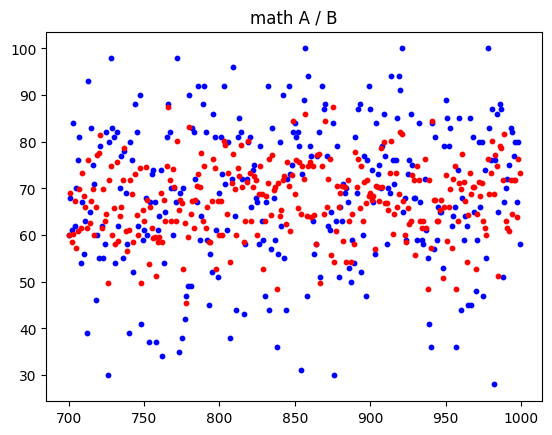

In [21]:
import matplotlib.pyplot as plt
plt.scatter(list(range(700, 1000)), data_for_tests['math score'].to_list(), color='blue', s=10)
plt.scatter(list(range(700, 1000)), multi_linear_approx(coeffs_a_math, test_Xs_a), color='red', s=10)
plt.title('math A / B')
plt.show()

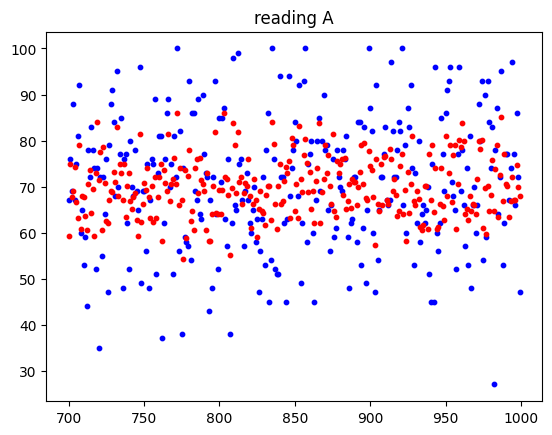

In [22]:
plt.scatter(list(range(700, 1000)), data_for_tests['reading score'].to_list(), color='blue', s=10)
plt.scatter(list(range(700, 1000)), multi_linear_approx(coeffs_a_read, test_Xs_a), color='red', s=10)
plt.title('reading A')
plt.show()

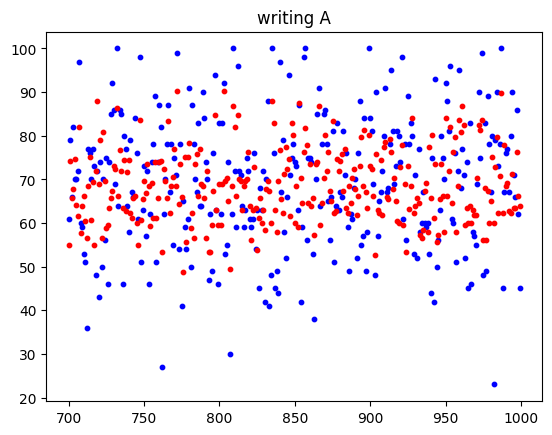

In [23]:
plt.scatter(list(range(700, 1000)), data_for_tests['writing score'].to_list(), color='blue', s=10)
plt.scatter(list(range(700, 1000)), multi_linear_approx(coeffs_a_write, test_Xs_a), color='red', s=10)
plt.title('writing A')
plt.show()

## Вывод -- продолжение
Линейная регрессия для предположения, что результаты экзаменов зависят от прошедших экзаменов имеет хорошую оценку $R^2$ ( кроме `math`, потому что это первый экзамен). На графике видно, что реальные и предсказанные значения зачастую довольно близки

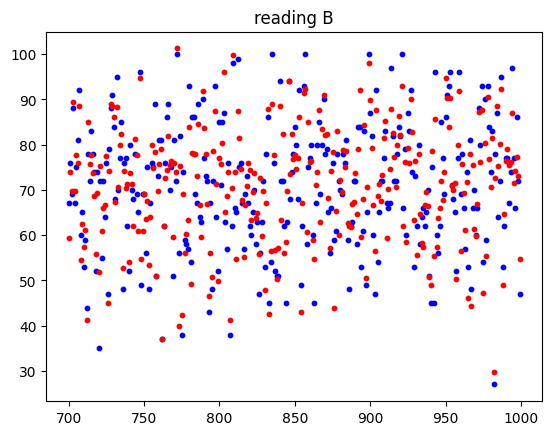

In [24]:
plt.scatter(list(range(700, 1000)), data_for_tests['reading score'].to_list(), color='blue', s=10)
plt.scatter(list(range(700, 1000)), multi_linear_approx(coeffs_b_read, test_Xs_b_read), color='red', s=10)
plt.title('reading B')
plt.show()

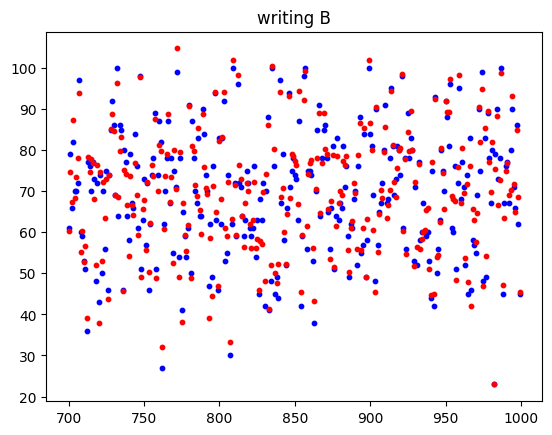

In [25]:
plt.scatter(list(range(700, 1000)), data_for_tests['writing score'].to_list(), color='blue', s=10)
plt.scatter(list(range(700, 1000)), multi_linear_approx(coeffs_b_write, test_Xs_b_write), color='red', s=10)
plt.title('writing B')
plt.show()

## Вывод -- заключение
Судя по данным, результат экзамена в меньшей степени определяется такими факторами как пол, этническая группа, уровень образования, питание, уровень подготовленности, и в большей -- результатами других экзаменов. Это же подтверждает корреляционная матрица:

In [27]:
data_for_tests.corr()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
gender,1.000000,-0.057056,0.002164,0.033045,0.029182,-0.156027,0.271032,0.305782
race/ethnicity,-0.057056,1.000000,-0.011768,0.017879,0.011173,0.248073,0.162129,0.188347
parental level of education,0.002164,-0.011768,1.000000,-0.021976,0.029985,0.182249,0.156890,0.200655
lunch,0.033045,0.017879,-0.021976,1.000000,-0.065870,0.418550,0.273079,0.266729
test preparation course,0.029182,0.011173,0.029985,-0.065870,1.000000,0.122535,0.247200,0.336228
math score,-0.156027,0.248073,0.182249,0.418550,0.122535,1.000000,0.798539,0.796816
reading score,0.271032,0.162129,0.156890,0.273079,0.247200,0.798539,1.000000,0.951761
writing score,0.305782,0.188347,0.200655,0.266729,0.336228,0.796816,0.951761,1.000000


можно заметить, что корреляция между результатами экзаменов значительно больше, чем между ними же и остальными параметрами.